# 1. Obtenció i tractament de dades

### 1.1 Ús de la llibreria LabelMe

In [ ]:
!labelme 

###  1.2 Creació de la base de dades

In [1]:
#importació de llibreries necessàries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import shutil
import math

In [ ]:
#limitació de la memòria GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
imatges = tf.data.Dataset.list_files('imatges\\*.jpg') # introduïm les imatges

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: imatges\\*.jpg'

In [10]:
def carregar_imatge(imatge): #funció per a carregar imatges
    byte_img = tf.io.read_file(imatge)
    img = tf.image.decode_jpeg(byte_img)
    return img

In [ ]:
imatges = imatges.map(carregar_imatge) #executem la funció 

In [ ]:
imatges.as_numpy_iterator().next() 

In [ ]:
def imatgesDividir(dir_carpeta, n_imatges):
    num_elements = len(os.listdir(os.path.join(dir_carpeta, "imatges")))
    n_train = round(num_elements*0.7) # 70% de les imatges per entrenar
    n_test = round(num_elements*0.15) # 15% de les imatges per provar
    n_val = num_elements - (n_train + n_test) # 15% de les imatges per validar

    llista = []
    for i in range(1, (n_imatges + 1)):
        llista.append(i)

    while len(llista) > n_train:
        if (len(os.listdir(os.path.join(dir_carpeta,"dades","test")))-1)< n_test:
            for i in range(n_test):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta, "imatges", nom ), os.path.join(dir_carpeta, "dades", "test" , "imatges"))
                llista.remove(n)

        if (len(os.listdir(os.path.join(dir_carpeta,"dades","val")))-1) < n_val:
            for i in range(n_val):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta, "imatges", nom), os.path.join(dir_carpeta,"dades" , "val", "imatges"))
                llista.remove(n)

    for i in llista:
        nom = str(i) + ".jpg"
        shutil.move(os.path.join(dir_carpeta, "imatges", nom), os.path.join(dir_carpeta, "dades","train", "imatges"))

In [ ]:
# Crear la carpeta principal
os.mkdir("dades")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("dades", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("dades", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("dades", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)

imatgesDividir('\practica_tr',300) #divisió de les carpetes i de les imatges

### Partició de les dades

In [ ]:
# mou les els labels a les seves respectives carpetes
def moureLabels(dir_carpeta):
    for carpeta in ['train','test','val']:
        for arxiu in os.listdir(os.path.join(dir_carpeta,'dades', carpeta, 'imatges')): #per cada arxiu en cada carpeta
            n = arxiu.split(".")
            json = str(n[0] + ".json")
            shutil.move(os.path.join(dir_carpeta, "labels", json ), os.path.join(dir_carpeta, "dades", carpeta, "labels"))#canviem

In [ ]:
moureLabels('\practica_tr')

### 1.2.1 Ús de la llibreria Albumentation

In [3]:
import albumentations as alb
import cv2

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=1024, height=1024),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.5),
                         alb.RandomGamma(p=0.7), 
                         alb.RGBShift(p=0.5), 
                         alb.VerticalFlip(p=0.7)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [6]:
os.mkdir("aug_dades")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("aug_dades", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("aug_dades", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("aug_dades", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)


In [7]:
classes_fruita = {"poma": [1,0,0], "pera": [0,1,0] , "mandarina": [0,0,1]}
partitions = ['train', 'test', 'val']

for partition in partitions:
    input_folder = os.path.join('dades', partition, 'imatges')
    output_folder = os.path.join('aug_dades', partition, 'imatges')

    for imatge in os.listdir(input_folder):
        img_path = os.path.join(input_folder, imatge)
        img = cv2.imread(img_path)
        label_path = os.path.join('dades', partition, 'labels', f'{imatge.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            for shape in label['shapes']:
                class_name = shape['label'] 
                class_id = classes_fruita[class_name]
                coords = shape['points']
                coords = [(coords[0][0]/1024), (coords[0][1]/1024), (coords[1][0]/1024), (coords[1][1]/1024)]

                try:
                    for x in range(5):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_name])
                        augmented_img = augmented['image']

                        annotation = {
                            'image': f'{imatge.split(".")[0]}.{x}.jpg',
                            'bbox': augmented['bboxes'],
                            'class': class_id,
                        }
                        output_img_path = os.path.join(output_folder, annotation['image'])
                        cv2.imwrite(output_img_path, augmented_img)

                        output_json_path = os.path.join('aug_dades', partition, 'labels', f'{imatge.split(".")[0]}.{x}.json')
                        with open(output_json_path, 'w') as f:
                            json.dump(annotation, f) 
                except Exception as e:
                    print(e)


Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)


### Incloure imatges creades amb Albumentations a la Dataset

In [11]:
train_imatges = tf.data.Dataset.list_files('aug_dades\\train\\imatges\\*.jpg',shuffle=False)
train_imatges = train_imatges.map(carregar_imatge)
train_imatges = train_imatges.map(lambda x: tf.image.resize(x, (120,120)))
train_imatges = train_imatges.map(lambda x: x/255)

In [12]:
test_imatges = tf.data.Dataset.list_files('aug_dades\\test\\imatges\\*.jpg', shuffle=False)
test_imatges = test_imatges.map(carregar_imatge)
test_imatges = test_imatges.map(lambda x: tf.image.resize(x, (120,120)))
test_imatges = test_imatges.map(lambda x: x/255)

In [13]:
val_imatges = tf.data.Dataset.list_files('aug_dades\\val\\imatges\\*.jpg', shuffle=False)
val_imatges = val_imatges.map(carregar_imatge)
val_imatges = val_imatges.map(lambda x: tf.image.resize(x, (120,120)))
val_imatges = val_imatges.map(lambda x: x/255)

In [ ]:
train_imatges.as_numpy_iterator().next()

### 2.5 Carregar labels

In [14]:
def carregar_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [15]:
train_labels = tf.data.Dataset.list_files('aug_dades\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [16]:
test_labels = tf.data.Dataset.list_files('aug_dades\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [17]:
val_labels = tf.data.Dataset.list_files('aug_dades\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

### Combinar etiquetes i imatges

In [18]:
num_elements={}
for carpeta in ['train','test','val']:
    x = len(os.listdir(os.path.join('aug_dades', carpeta, 'imatges')))
    num_elements.update({carpeta : round(x * 1.5)})

In [19]:
train = tf.data.Dataset.zip((train_imatges, train_labels))
train = train.shuffle(num_elements['train'])
train = train.batch(5)
train = train.prefetch(4)

In [20]:
test = tf.data.Dataset.zip((test_imatges, test_labels))
test = test.shuffle(num_elements['test'])
test = test.batch(5)
test = test.prefetch(4)

In [21]:
val = tf.data.Dataset.zip((val_imatges, val_labels))
val = val.shuffle(num_elements['val'])
val = val.batch(5)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()

# 2. Preparació de la intel·ligència artificial

### 2.1 Descarregar i carregar el model VGG16

In [22]:
import tensorflow.keras.models
import tensorflow.keras.layers
import tensorflow.keras.applications

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [24]:
vgg = VGG16(include_top=False) 

In [25]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    #Model de classificació
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) #relu == funció que determina la classe; 
    class2 = Dense(3, activation='sigmoid')(class1) # sigmoid == funció que determina la presició de la classe

    # sigmoid = f(x) = 1/(1+e^-x)
    
    #Model de localització de coordenades
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    detector = Model(inputs=input_layer, outputs=[class2, regress2])
    return detector

In [26]:
detector = build_model()

### 2.2 Funcions de pèrdua i optimitzadors

In [27]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) 

#### Creació de 'Localitzation Loss' i 'Classification Loss'

In [28]:
def localization_loss(y_true, yhat):#primer valor: coordenades reals, segon valor: coordenades previstes     
    y_true = tf.reshape(y_true, (5, 4))
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #diferència dels dos primers valors de cada fila de la matriu
                  
    h_true = y_true[:,3] - y_true[:,1] #quarta columna d'una matriu - segona columna
    w_true = y_true[:,2] - y_true[:,0] #tercera columna - primera

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    '''
    delta_size = suma dels quadrats de les diferències entre les dimensions originals 
    i les dimensions reconstruïdes de l'imatge.
    '''
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [29]:
classloss = tf.keras.losses.CategoricalCrossentropy() #model que fa una classificació binaria 
regressloss = localization_loss #model que acabem de crear

# 3. Entrenament de la intel·ligència artificial

### 3.1 Creació del propi model 

In [30]:
import keras
from tensorflow.keras.utils import serialize_keras_object

In [32]:
tf.keras.utils.get_custom_objects().clear()
#registrem un model personalitzat
@tf.keras.utils.register_keras_serializable(package="MyLayers")
class Detector(Model):
    def __init__(self, fruita, **kwargs):
        super().__init__(**kwargs)
        self.base_model = fruita

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.base_model(X, training=True)
            batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

        grad = tape.gradient(total_loss, self.base_model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.base_model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.base_model(X, training=False)

        batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.base_model(X, **kwargs)
    
    def get_config(self):
        base_config = super().get_config()
        fruita_config = serialize_keras_object(self.base_model)
        config = {
            "fruita": fruita_config,
        }
        return {**base_config, **config}



In [33]:
detector.build(input_shape=(5, 120, 120, 3))
model = Detector(detector)

In [34]:
model.compile(opt, classloss, regressloss)

### 3.2 Entrenament


In [ ]:
logdir='logs' #Crea un directori on es guardarà la informació del Tensorboard 

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #crea un callback per registrar la informació del model 

In [ ]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

### 3.3 Anàlisi del rendiment de l'entrenament

In [ ]:
hist.history #per veure totes les pèrdues (losses)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
model.save_weights('detector_fruites_weights.h5')

### PROVA DEL MODEL 

In [35]:
model.build(input_shape=(5, 120, 120, 3))

In [36]:
model.load_weights('detector_fruites_weights.h5')

In [63]:
test_data = test.as_numpy_iterator()

In [64]:
test_sample = test_data.next()
print (test_sample)

(array([[[[0.7086754 , 0.71421355, 0.69089764],
         [0.7088889 , 0.71281046, 0.6932026 ],
         [0.7060349 , 0.70995647, 0.6903486 ],
         ...,
         [0.7088889 , 0.7088889 , 0.70104575],
         [0.70132023, 0.70916337, 0.69739866],
         [0.7019608 , 0.70980394, 0.69846636]],

        [[0.7049673 , 0.710719  , 0.6862745 ],
         [0.7058824 , 0.70980394, 0.6862745 ],
         [0.7058824 , 0.70980394, 0.6862745 ],
         ...,
         [0.70862746, 0.70862746, 0.70862746],
         [0.7058824 , 0.7137255 , 0.70980394],
         [0.7049671 , 0.70679766, 0.69803923]],

        [[0.70980394, 0.70980394, 0.7019608 ],
         [0.7058824 , 0.70980394, 0.6862745 ],
         [0.7026144 , 0.706536  , 0.6830066 ],
         ...,
         [0.7130716 , 0.7209147 , 0.7013069 ],
         [0.7137255 , 0.7137255 , 0.7058824 ],
         [0.7137255 , 0.7137255 , 0.7058824 ]],

        ...,

        [[0.5137255 , 0.5176471 , 0.49803922],
         [0.5120912 , 0.5160128 , 0.49248344

In [68]:
print (test_sample[0])
yhat = model.predict(test_sample[0])

[[[[0.7086754  0.71421355 0.69089764]
   [0.7088889  0.71281046 0.6932026 ]
   [0.7060349  0.70995647 0.6903486 ]
   ...
   [0.7088889  0.7088889  0.70104575]
   [0.70132023 0.70916337 0.69739866]
   [0.7019608  0.70980394 0.69846636]]

  [[0.7049673  0.710719   0.6862745 ]
   [0.7058824  0.70980394 0.6862745 ]
   [0.7058824  0.70980394 0.6862745 ]
   ...
   [0.70862746 0.70862746 0.70862746]
   [0.7058824  0.7137255  0.70980394]
   [0.7049671  0.70679766 0.69803923]]

  [[0.70980394 0.70980394 0.7019608 ]
   [0.7058824  0.70980394 0.6862745 ]
   [0.7026144  0.706536   0.6830066 ]
   ...
   [0.7130716  0.7209147  0.7013069 ]
   [0.7137255  0.7137255  0.7058824 ]
   [0.7137255  0.7137255  0.7058824 ]]

  ...

  [[0.5137255  0.5176471  0.49803922]
   [0.5120912  0.5160128  0.49248344]
   [0.5110025  0.51492405 0.49139458]
   ...
   [0.5254902  0.5137255  0.49411765]
   [0.5294118  0.50980395 0.49803922]
   [0.52498895 0.5093027  0.5053811 ]]

  [[0.5137255  0.5137255  0.5058824 ]
   [0.5

In [69]:
print(yhat)

[array([[1.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [8.2636929e-01, 8.2836312e-01, 2.1284332e-02],
       [1.0000000e+00, 2.4191378e-38, 6.3511657e-34],
       [2.5552660e-02, 5.7887536e-02, 9.9731141e-01]], dtype=float32), array([[3.65192676e-09, 2.44165335e-07, 9.99359608e-01, 1.00000000e+00],
       [5.47793988e-08, 4.31842513e-11, 1.00000000e+00, 1.00000000e+00],
       [2.73635238e-01, 1.44412816e-01, 7.88893104e-01, 7.76491225e-01],
       [1.09236516e-10, 1.39797661e-11, 1.00000000e+00, 1.00000000e+00],
       [3.32931340e-01, 2.74800599e-01, 7.28881299e-01, 7.09080458e-01]],
      dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


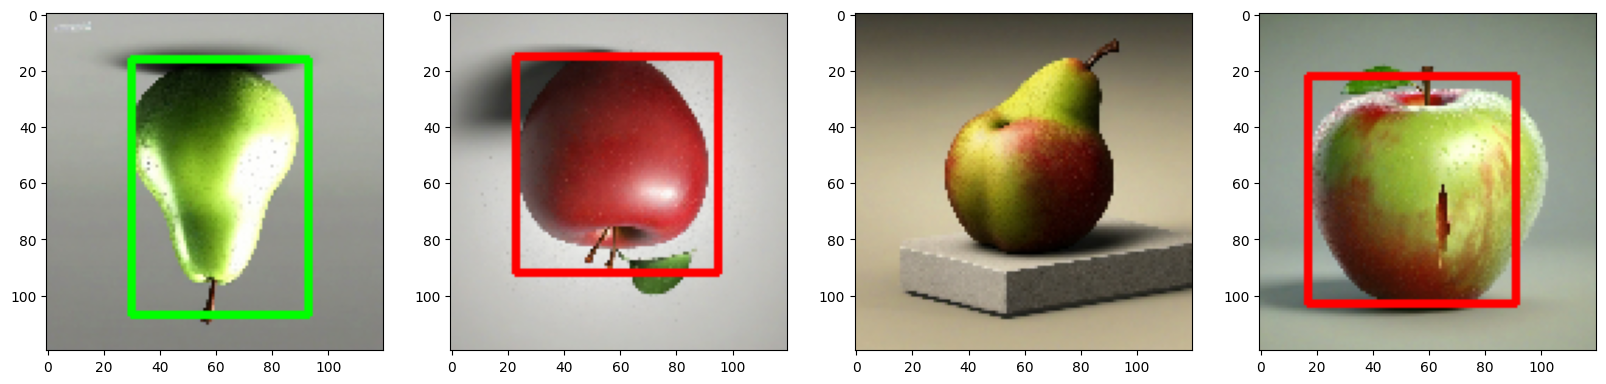

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx][0] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    elif yhat[0][idx][1] > 0.9:
            cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (0,255,0), 2)

    elif yhat[0][idx][2] > 0.9:
         cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,170,0), 2)
    
    ax[idx].imshow(sample_image)